In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [2]:
w_dir = os.getcwd()
files = [_ for _ in os.listdir() if 'npz' in _]

# to_remove = ['.ipynb_checkpoints','test_set_master_guess_array.npy',
#              'Sparsity_summary_confusion_matrices.ipynb',
#              'test_set_cifar_labels.npy']
# print('')
# for removable in to_remove:
#     try:
#         files.remove(removable)
#     except:
#         print(removable + ' not found...')

print(files)

['densenet_BC_100_12.npz', 'resnext_29_8x64d.npz', 'shake_shake_26_2x64d_SSI_cutout16.npz', 'pyramidnet_basic_110_270.npz', 'vgg_15_BN_64.npz', 'resnet_basic_110.npz', 'resnet_preact_bottleneck_164.npz', 'wrn_28_10_cutout16.npz']


In [3]:
ground_labels = np.int_(np.load('test_set_cifar_labels.npy'))
master_guess_array = np.load('test_set_master_guess_array.npy')
categories = ['plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(files)

def file_loader(path):
    a = np.load(path)
    return a['labels'], a['outputs'], a['accuracy']

def hist_guesess(guess_array, num_c=10):
    out = np.empty((len(guess_array), num_c))
    
    for i, guess_list in enumerate(guess_array):
        out[i] = np.bincount(guess_list, minlength=num_c)
        
    return out

def top_1(hist_array):
    """Can be hist of softmax"""
    return np.argmax(hist_array, axis=1)

['densenet_BC_100_12.npz', 'resnext_29_8x64d.npz', 'shake_shake_26_2x64d_SSI_cutout16.npz', 'pyramidnet_basic_110_270.npz', 'vgg_15_BN_64.npz', 'resnet_basic_110.npz', 'resnet_preact_bottleneck_164.npz', 'wrn_28_10_cutout16.npz']


In [4]:
# make human matrices

guess_hist = hist_guesess(master_guess_array)
print(guess_hist.shape, guess_hist[:5])

# normalizes, so each row sums to one and mirror softmax
guess_hist_softmax = guess_hist/np.sum(guess_hist, axis=1)[:, np.newaxis] 

guess_top_1 = top_1(guess_hist)
print(guess_top_1.shape, guess_top_1[:5])

(10000, 10) [[ 0.  1.  1. 48.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. 50.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 52.  0.]
 [38.  0.  8.  0.  1.  0.  1.  0.  2.  1.]
 [ 0.  0.  1.  0.  0.  0. 50.  0.  0.  0.]]
(10000,) [3 8 8 0 6]


In [5]:
# confusion matrix code
def convert_gt_1d(gt_1d, nc=False):
    """Creates matrix of size len(gt_1d)=samples, num_classes"""
    print(gt_1d.shape)
    
    ns = gt_1d.shape[0]
    print('num samples: ', np.int(ns))
    
    if not nc:
        nc = np.int(len(set(gt_1d.flatten())))
        print('num classes: ', nc)
        
    new_mat = np.zeros((ns, nc))
    
    rows = np.arange(gt_1d.shape[0])
        
    new_mat[rows, gt_1d] +=1
    
    return new_mat
    

def conf_matrix(one_hot_array, ground_truths):
    """Expects an array to be samples by classes"""
    try:
        nc = one_hot_array.shape[1]
    except:
        one_hot_array = convert_gt_1d(one_hot_array)
        nc = one_hot_array.shape[1]
        
    cm = np.empty((nc, nc))
    for cat in np.arange(nc):
        cm[cat] = np.mean(one_hot_array[np.where(ground_truths==cat)[0]], axis = 0)
    
    np.fill_diagonal(cm, 0)
    return cm

In [6]:
def dict_saver(model, di, s_dir):
    with open(s_dir + '/' + model + '_all_cms.p', 'wb') as pfile:
        pickle.dump(di, pfile)

s_dir = os.path.join(w_dir, 'matrices')
#print(s_dir)
if not os.path.exists(s_dir):
    os.mkdir(s_dir)
    
temp_d = {}
temp_d['cm_raw'] = conf_matrix(guess_hist, ground_labels)
temp_d['softmax'] = conf_matrix(guess_hist_softmax, ground_labels)
temp_d['gt'] = conf_matrix(guess_top_1, ground_labels)

dict_saver('Human', temp_d, s_dir)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

for model_file in files:
    print(model_file)
    t_labs, t_outs, t_acc = file_loader(model_file)
    temp_d = {}
    for t_i in range(t_outs.shape[0]): t_outs[t_i] = softmax(t_outs[t_i])
    temp_d['softmax'] = conf_matrix(t_outs, ground_labels)
    temp_d['gt'] = conf_matrix(top_1(t_outs), ground_labels)
    dict_saver(model_file.split('.')[0], temp_d, s_dir)

(10000,)
num samples:  10000
num classes:  10
densenet_BC_100_12.npz
(10000,)
num samples:  10000
num classes:  10
resnext_29_8x64d.npz
(10000,)
num samples:  10000
num classes:  10
shake_shake_26_2x64d_SSI_cutout16.npz
(10000,)
num samples:  10000
num classes:  10
pyramidnet_basic_110_270.npz
(10000,)
num samples:  10000
num classes:  10
vgg_15_BN_64.npz
(10000,)
num samples:  10000
num classes:  10
resnet_basic_110.npz
(10000,)
num samples:  10000
num classes:  10
resnet_preact_bottleneck_164.npz
(10000,)
num samples:  10000
num classes:  10
wrn_28_10_cutout16.npz
(10000,)
num samples:  10000
num classes:  10


In [7]:
def cm_fig(cm, model, labels, s_dir=False):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title('Confusion matrix: {0}'.format(model), fontsize = 20)
    ax.set_xlabel('Chosen', fontsize = 15)
    ax.set_ylabel('Ground truth', fontsize = 15)

    cax = ax.matshow(cm, cmap='Reds', interpolation = 'nearest')
    cbar = fig.colorbar(cax)
    #print(ax.get_xticks())
    ax.xaxis.set_ticks(np.arange(10))
    #print(ax.get_xticks())
    ax.yaxis.set_ticks(np.arange(10))

    ax.set_xticklabels(labels)

    ax.set_yticklabels(labels)
    
    if s_dir:
        plt.savefig(s_dir + '/' + model + '_confusion_matrix.png', bbox_inches="tight")

In [8]:
def dict_loader(path):
    with open(path, 'rb') as pfile:
        return pickle.load(pfile)

cm_files = os.listdir(w_dir + '/matrices')

# for file in cm_files:
#     di = dict_loader(w_dir + '/matrices/' + file)
#     model_name = file.split('_a')[0]
#     cm_fig(di['softmax'], model_name, w_dir + '/figures/' + model_name)
#     cm_fig(di['gt'], model_name + '_gt', w_dir + '/figures/' + model_name + '_gt')

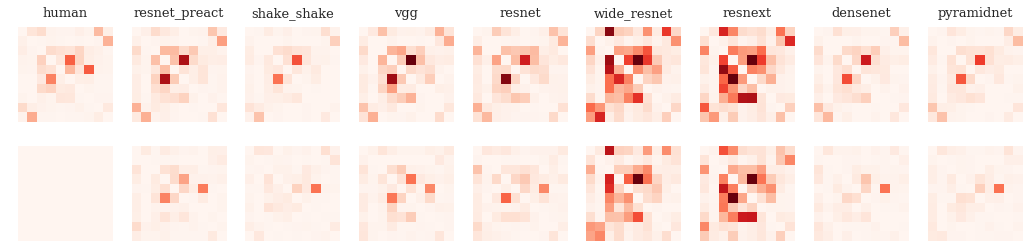

In [18]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

cm_files = os.listdir(w_dir + '/matrices')

f, axes = plt.subplots(2, 9, figsize=(18,4))#, sharey=True)
cm_files.remove('Human_all_cms.p')
cm_files.insert(0, 'Human_all_cms.p')

labels = [c[0].upper() for c in categories]

titles = ['human', 'resnet_preact', 
          'shake_shake', 'vgg', 
          'resnet', 'wide_resnet', 
          'resnext', 'densenet', 
          'pyramidnet']

for i, file in enumerate(cm_files):

    di = dict_loader(w_dir + '/matrices/' + file)
    if 'Human' in file: 
        human_di = di.copy()
    model_name = file.split('_a')[0]
    
    axes[0][i].set_title(titles[i], fontsize=13) #file[:-10], fontsize=8) # titles[i]
    axes[0][i].matshow(di['softmax'], vmin=0, vmax=0.08046593517065048,
                       cmap='Reds', interpolation = 'nearest')
    axes[0][i].axis('off')
#     axes[0][i].xaxis.set_ticks(np.arange(10)-0.5)
#     axes[0][i].yaxis.set_ticks(np.arange(10)-0.5)
#     axes[0][i].set_xticklabels(['']+labels)
#     axes[0][i].set_yticklabels(['']+labels)
#     axes[0][i].tick_params(axis=u'both', which=u'both', length=0)
#     for spine_key in axes[0][i].spines.keys():
#         axes[0][i].spines[spine_key].set_visible(False)

    axes[1][i].matshow(np.abs(human_di['softmax']-di['softmax']), vmin=0, vmax=0.08046593517065048,
                       cmap='Reds', interpolation = 'nearest')
    axes[1][i].axis('off')
#     axes[1][i].xaxis.set_ticks(np.arange(10)-0.5)
#     axes[1][i].yaxis.set_ticks(np.arange(10)-0.5)
#     axes[1][i].set_xticklabels(['']+labels)
#     axes[1][i].set_yticklabels(['']+labels)
#     axes[1][i].tick_params(axis=u'both', which=u'both',length=0)
#     for spine_key in axes[0][i].spines.keys():
#         axes[1][i].spines[spine_key].set_visible(False)